# Install dependencies - Done

The `unicodecsv` library is needed for reading and manipulating CSV data. Since student enrollment info is in a CSV, we will need this library.

In [184]:
# Uncomment and run the following lines of code to install dependencies, if not already installed
#!pip install unicodecsv
#!pip install numpy
#!pip install matplotlib

You should consider upgrading via the 'c:\users\alimd\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.



## Load Data from CSVs - Done

We have the following csv files containing student data.

1. enrollments.csv
2. daily_engagement.csv
3. project_submissions.csv

In this section, each of these CSV files is loaded into the code, and stored in Python variables.

In [11]:
import unicodecsv

## Longer version of code (replaced with shorter, equivalent version below)

# enrollments = []
# f = open('enrollments.csv', 'rb')
# reader = unicodecsv.DictReader(f)
# for row in reader:
#     enrollments.append(row)
# f.close()

with open('enrollments.csv', 'rb') as f:
    reader = unicodecsv.DictReader(f)    enroollments = list(reader)

In [12]:
#####################################
#                 1                 #
#####################################

## Read in the data from daily_engagement.csv and project_submissions.csv 
## and store the results in the below variables.
## Then look at the first row of each table.

def csv_as_list(filename):
    with open(filename, 'rb') as f:
        csvList = list(unicodecsv.DictReader(f))
    return csvList

daily_engagement = csv_as_list('daily_engagement.csv')
print(daily_engagement[0])
project_submissions = csv_as_list('project_submissions.csv')
print(project_submissions[0])

{'acct': '0', 'utc_date': '2015-01-09', 'num_courses_visited': '1.0', 'total_minutes_visited': '11.6793745', 'lessons_completed': '0.0', 'projects_completed': '0.0'}
{'creation_date': '2015-01-14', 'completion_date': '2015-01-16', 'assigned_rating': 'UNGRADED', 'account_key': '256', 'lesson_key': '3176718735', 'processing_state': 'EVALUATED'}


## Fixing Data Types - Done

The second part of Data Wrangling - that is, _Data Cleaning_ - phase begins here.

In [13]:
from datetime import datetime as dt

# Takes a date as a string, and returns a Python datetime object. 
# If there is no date given, returns None
def parse_date(date):
    if date == '':
        return None
    else:
        return dt.strptime(date, '%Y-%m-%d')
    
# Takes a string which is either an empty string or represents an integer,
# and returns an int or None.
def parse_maybe_int(i):
    if i == '':
        return None
    else:
        return int(i)

# Clean up the data types in the enrollments table
for enrollment in enrollments:
    enrollment['cancel_date'] = parse_date(enrollment['cancel_date'])
    enrollment['days_to_cancel'] = parse_maybe_int(enrollment['days_to_cancel'])
    enrollment['is_canceled'] = enrollment['is_canceled'] == 'True'
    enrollment['is_udacity'] = enrollment['is_udacity'] == 'True'
    enrollment['join_date'] = parse_date(enrollment['join_date'])
    
enrollments[0]

{'account_key': '448',
 'status': 'canceled',
 'join_date': datetime.datetime(2014, 11, 10, 0, 0),
 'cancel_date': datetime.datetime(2015, 1, 14, 0, 0),
 'days_to_cancel': 65,
 'is_udacity': True,
 'is_canceled': True}

In [108]:
# Commenting out the following block as it was purely for debugging
# debug_daily_engagement = csv_as_list('daily_engagement.csv')
# extra_minutes = []
# for record in debug_daily_engagement:
#     print(record['total_minutes_visited'], end=', ')
#     minutes = float(record['total_minutes_visited'])
#     if minutes >= 24 * 60 or str(minutes) != record['total_minutes_visited']:
#         extra_minutes.append(minutes)
#         print(minutes)
# print(extra_minutes)

In [14]:
# Clean up the data types in the engagement table
for engagement_record in daily_engagement:
    engagement_record['lessons_completed'] = int(float(engagement_record['lessons_completed']))
    engagement_record['num_courses_visited'] = int(float(engagement_record['num_courses_visited']))
    engagement_record['projects_completed'] = int(float(engagement_record['projects_completed']))
    engagement_record['total_minutes_visited'] = float(engagement_record['total_minutes_visited'])
    engagement_record['utc_date'] = parse_date(engagement_record['utc_date'])
    
daily_engagement[0]

{'acct': '0',
 'utc_date': datetime.datetime(2015, 1, 9, 0, 0),
 'num_courses_visited': 1,
 'total_minutes_visited': 11.6793745,
 'lessons_completed': 0,
 'projects_completed': 0}

In [15]:
# Clean up the data types in the submissions table
for submission in project_submissions:
    submission['completion_date'] = parse_date(submission['completion_date'])
    submission['creation_date'] = parse_date(submission['creation_date'])

project_submissions[0]

{'creation_date': datetime.datetime(2015, 1, 14, 0, 0),
 'completion_date': datetime.datetime(2015, 1, 16, 0, 0),
 'assigned_rating': 'UNGRADED',
 'account_key': '256',
 'lesson_key': '3176718735',
 'processing_state': 'EVALUATED'}

## Problems in the Data - Done

**Note**: I've switched the order of blocks 2 and 3 because the changes in block 3 are needed in some wrangling of block 2.

In [16]:
#####################################
#                 3                 #
#####################################

## Rename the "acct" column in the daily_engagement table to "account_key".
for engagement in daily_engagement:
    temp = engagement['acct']
    del engagement['acct']
    engagement['account_key'] = temp

## Investigating the Data - Done

In [17]:
#####################################
#                 2                 #
#####################################

## Find the total number of rows and the number of unique students (account keys)
## in each table.

def investigate(csvList):
    csvListLen = len(csvList)
    unique_elems = len(set([list_item['account_key'] for list_item in csvList]))
    return csvListLen, unique_elems

enrollment_num_rows, enrollment_num_unique_students = investigate(enrollments)

engagement_num_rows, engagement_num_unique_students = investigate(daily_engagement)

submission_num_rows, submission_num_unique_students = investigate(project_submissions)

print (enrollment_num_unique_students, engagement_num_unique_students, submission_num_unique_students)

1302 1237 743


In [19]:
print(daily_engagement[1000]['account_key'])

6


## Missing Engagement Records - Done

So in the above output, the enrollment data is 1302 but engagement data is 1237.
Meaning there are students enrolled not having any engagement. Find those students out!

In [20]:
#####################################
#                 4                 #
#####################################

## Find any one student enrollments where the student is missing from the daily engagement table.
## Output that enrollment.
engagement_keys = list(set([engagement['account_key'] for engagement in daily_engagement]))
enrolled_students_without_engagement = [student for student in enrollments if student['account_key'] not in engagement_keys]

In [21]:
print(enrolled_students_without_engagement[0])

{'account_key': '1219', 'status': 'canceled', 'join_date': datetime.datetime(2014, 11, 12, 0, 0), 'cancel_date': datetime.datetime(2014, 11, 12, 0, 0), 'days_to_cancel': 0, 'is_udacity': False, 'is_canceled': True}


### Explanation
We see there are students who cancelled the same day they enrolled in, which is why they appear in the enrollments table, but not in the engagements table.

To see just how many of such students are there, run the following command.

In [22]:
print(len(enrolled_students_without_engagement))

71


## Checking for More Problem Records - Done

In [23]:
#####################################
#                 5                 #
#####################################

## Find the number of surprising data points (enrollments missing from
## the engagement table) that remain, if any.
students_staying_one_day_min = []
for student in enrollments:
    if student['account_key'] not in engagement_keys and student['days_to_cancel'] is None:
        students_staying_one_day_min.append(student)
    elif student['account_key'] not in engagement_keys and student['days_to_cancel'] is not None and student['days_to_cancel'] > 0:
        students_staying_one_day_min.append(student)

In [24]:
print(len(students_staying_one_day_min))

3


In [25]:
print(students_staying_one_day_min)

[{'account_key': '1304', 'status': 'canceled', 'join_date': datetime.datetime(2015, 1, 10, 0, 0), 'cancel_date': datetime.datetime(2015, 3, 10, 0, 0), 'days_to_cancel': 59, 'is_udacity': True, 'is_canceled': True}, {'account_key': '1304', 'status': 'canceled', 'join_date': datetime.datetime(2015, 3, 10, 0, 0), 'cancel_date': datetime.datetime(2015, 6, 17, 0, 0), 'days_to_cancel': 99, 'is_udacity': True, 'is_canceled': True}, {'account_key': '1101', 'status': 'current', 'join_date': datetime.datetime(2015, 2, 25, 0, 0), 'cancel_date': None, 'days_to_cancel': None, 'is_udacity': True, 'is_canceled': False}]


### Explanation

These students are all Udacity test accounts (we can tell since for each of them, `is_udacity` is `True`). There is no guarentee that Udacity test accounts will appear in enrollments.

## Tracking Down the Remaining Problems - Done

In [26]:
# Create a set of the account keys for all Udacity test accounts
udacity_test_accounts = set()
for enrollment in enrollments:
    if enrollment['is_udacity']:
        udacity_test_accounts.add(enrollment['account_key'])
len(udacity_test_accounts)

6

In [27]:
# Given some data with an account_key field, removes any records corresponding to Udacity test accounts
def remove_udacity_accounts(data):
    non_udacity_data = []
    for data_point in data:
        if data_point['account_key'] not in udacity_test_accounts:
            non_udacity_data.append(data_point)
    return non_udacity_data

In [64]:
# Remove Udacity test accounts from all three tables
non_udacity_enrollments = remove_udacity_accounts(enrollments)
non_udacity_engagement = remove_udacity_accounts(daily_engagement)
non_udacity_submissions = remove_udacity_accounts(project_submissions)

print (len(non_udacity_enrollments))
print (len(non_udacity_engagement))
print (len(non_udacity_submissions))

1622
135656
3634


## Refining the Question - Done

Here, we ask the question this data analysis is suppose to answer. Additionally, we are now entering the Exploration Phase.

### Question
> How do the daily engagement attributes of students who pass their first project differ from those who don't?

### Problems
1. **`[High]`** The students are most likely to submit their projects during different intervals of time. A student might submit the first project by the end of the first week and another might submit it by the end of the first month, for example. These varying submission times will have varying engagement trends, and hence it is unfair to compare engagement across different ranges of time of students who submit.
2. **`[High]`** If you look at all submission info present in `daily_engagement` table, it contains engagement even after the submission of the first project. Those trends are of no use for the question posed, and would lead to incorrect analysis.
3. `[Low]` The total amount of info present in the `daily_engagement` table is for the entire course, and not just the project submissions. Hence you will be having a lot of data points that you won't be needing in answering the above question.

In order to tackle these problems, we start by eliminating the students who cancelled within the first week.

In [56]:
#####################################
#                 6                 #
#####################################

## Create a dictionary named paid_students containing all students who either
## haven't canceled yet or who remained enrolled for more than 7 days. The keys
## should be account keys, and the values should be the date the student enrolled.

paid_students = dict()
for student in non_udacity_enrollments:
    if student['cancel_date'] is None or student['days_to_cancel'] > 7:
        account_key = student['account_key']
        join_date = student['join_date']

        # add this entry to the dictionary only if it is already not there
        # and if it is the most recent enrollment
        if account_key not in paid_students or join_date > paid_students[account_key]:
            paid_students[account_key] = join_date

print(len(paid_students))

995


## Getting Data from First Week - Done

Next, to compare engagements across the same amount of time of students who have submitted, we extract engagement data in only the first week.

In [116]:
# Takes a student's join date and the date of a specific engagement record,
# and returns True if that engagement record happened within one week
# of the student joining.
def within_one_week(join_date, engagement_date):
    time_delta = engagement_date - join_date
    # buggy condition:
    # return time_delta.days < 7
    # correct condition:
    return time_delta.days < 7 and time_delta.days >= 0

In [117]:
#####################################
#                 7                 #
#####################################

## Create a list of rows from the engagement table including only rows where
## the student is one of the paid students you just found, and the date is within
## one week of the student's join date.

paid_engagement_in_first_week = [
    engagement for engagement in non_udacity_engagement if engagement['account_key'] in paid_students and within_one_week(paid_students[engagement['account_key']], engagement['utc_date'])
]
# print(non_udacity_engagement[0])
print(paid_engagement_in_first_week[0])
print(len(paid_engagement_in_first_week))

{'utc_date': datetime.datetime(2015, 1, 9, 0, 0), 'num_courses_visited': 1, 'total_minutes_visited': 11.6793745, 'lessons_completed': 0, 'projects_completed': 0, 'account_key': '0'}
6919


In [118]:
# Commenting out the following block as it was purely for debugging

# for record in paid_engagement_in_first_week:
#     minutes = 10080
#     visited = float(record['total_minutes_visited'])
#     visitNum = 0
#     if visited >= minutes:
#         visitNum += 1
#         print(visited, end=", ")
# print(f'visitnum: {visitNum}')
# print(paid_engagement_in_first_week[0])

# most = 0
# for record in paid_engagement_in_first_week:
#     if record['total_minutes_visited'] > most:
#         most = record['total_minutes_visited']
# print(f'most: {most}')


visitnum: 0
{'utc_date': datetime.datetime(2015, 1, 9, 0, 0), 'num_courses_visited': 1, 'total_minutes_visited': 11.6793745, 'lessons_completed': 0, 'projects_completed': 0, 'account_key': '0'}
most: 1030.88319667


In [119]:
# Now, to go along with the official solution, I would like to create the 3 variables I might need later, containing info of paid students.
def filter_out_unpaid_students(data):
    paid_data = [
        data_point for data_point in data if data_point['account_key'] in paid_students
    ]
    return paid_data

paid_enrollments = filter_out_unpaid_students(non_udacity_enrollments)
paid_engagement = filter_out_unpaid_students(non_udacity_engagement)
paid_submissions = filter_out_unpaid_students(non_udacity_submissions)

print(len(paid_enrollments))
print(len(paid_engagement))
print(len(paid_submissions))

1293
134549
3618


## Exploring Student Engagement - Done

In [120]:
from collections import defaultdict

# Create a dictionary of engagement grouped by student.
# The keys are account keys, and the values are lists of engagement records.
engagement_by_account = defaultdict(list)
for engagement_record in paid_engagement_in_first_week:
    account_key = engagement_record['account_key']
    engagement_by_account[account_key].append(engagement_record)

In [121]:
print(engagement_by_account['0'])

[{'utc_date': datetime.datetime(2015, 1, 9, 0, 0), 'num_courses_visited': 1, 'total_minutes_visited': 11.6793745, 'lessons_completed': 0, 'projects_completed': 0, 'account_key': '0'}, {'utc_date': datetime.datetime(2015, 1, 10, 0, 0), 'num_courses_visited': 2, 'total_minutes_visited': 37.2848873333, 'lessons_completed': 0, 'projects_completed': 0, 'account_key': '0'}, {'utc_date': datetime.datetime(2015, 1, 11, 0, 0), 'num_courses_visited': 2, 'total_minutes_visited': 53.6337463333, 'lessons_completed': 0, 'projects_completed': 0, 'account_key': '0'}, {'utc_date': datetime.datetime(2015, 1, 12, 0, 0), 'num_courses_visited': 1, 'total_minutes_visited': 33.4892696667, 'lessons_completed': 0, 'projects_completed': 0, 'account_key': '0'}, {'utc_date': datetime.datetime(2015, 1, 13, 0, 0), 'num_courses_visited': 1, 'total_minutes_visited': 64.7796776667, 'lessons_completed': 0, 'projects_completed': 0, 'account_key': '0'}, {'utc_date': datetime.datetime(2015, 1, 14, 0, 0), 'num_courses_visi

In [109]:
# Commenting out the following block as it was purely for debugging

# debug_engagement_by_account = defaultdict(list)
# for debug_engagement in paid_engagement_in_first_week:
#     account_key = engagement_record['account_key']
#     if debug_engagement not in debug_engagement_by_account['account_key']:
#         debug_engagement_by_account[account_key].append(debug_engagement)

In [110]:
# print(len(debug_engagement_by_account))
# print(len(engagement_by_account))

In [122]:
# Create a dictionary with the total minutes each student spent in the classroom during the first week.
# The keys are account keys, and the values are numbers (total minutes)
total_minutes_by_account = {}
for account_key, engagement_for_student in engagement_by_account.items():
    total_minutes = 0
    for engagement_record in engagement_for_student:
        total_minutes += engagement_record['total_minutes_visited']
    total_minutes_by_account[account_key] = total_minutes

In [123]:
import numpy as np

# Summarize the data about minutes spent in the classroom
total_minutes = list(total_minutes_by_account.values())
print ('Mean:', np.mean(total_minutes))
print ('Standard deviation:', np.std(total_minutes))
print ('Minimum:', np.min(total_minutes))
print ('Maximum:', np.max(total_minutes))

Mean: 306.70832675342825
Standard deviation: 412.99693340852957
Minimum: 0.0
Maximum: 3564.7332644989997


### Issue

Here we saw that the maximum minutes in a week spent by a student is 10568, but each week only contains 10,080 minutes. So our calculation is impossible, and we will have to investigate the why it is so. The following cell, and many cells above, contain debugging related to finding out the bug, and they are all commented out as they don't add to the code.

In [111]:
# Commenting out the following block as it was purely for debugging

# most = 0
# for minutes in list(total_minutes_by_account.values()):
#     if minutes > most:
#         most = minutes
# print(most)

# most = 10080
# extra = []
# for minutes in list(total_minutes_by_account.values()):
#     if minutes > most:
#         extra.append(minutes)
# print(extra)
# print(len(extra))

## Debugging Data Analysis Code

In [124]:
#####################################
#                 8                 #
#####################################

## Go through a similar process as before to see if there is a problem.
## Locate at least one surprising piece of data, output it, and take a look at it.

# Commenting out the following block as it was purely for debugging

# student_with_max_minutes = None
# max_minutes = 0

# for student, total_minutes in total_minutes_by_account.items():
#     if total_minutes > max_minutes:
#         max_minutes = total_minutes
#         student_with_max_minutes = student
# print(max_minutes)
# print(student_with_max_minutes)max_minutes = 0

# for student, total_minutes in total_minutes_by_account.items():
#     if total_minutes > max_minutes:
#         max_minutes = total_minutes
#         student_with_max_minutes = student
# print(max_minutes)
# print(student_with_max_minutes)

In [126]:
# Commenting out the following block as it was purely for debugging
#  for record in paid_engagement_in_first_week:
#     if record['account_key'] == student_with_max_minutes:
#         print(record)

### Observation

Here we see that the entries are much more than 7, which means when we sliced the data upto the first seven days, we ended up slicing more than that. Which means the `within_one_week` method is incorrect. Looking back at it, we are merely checking if the number of days < 7, but we are not checking if they are greater than 0. So any number less than 7 has its record added to the entry. We need to fix this by adding the needed condition.

So the needed condition was added and the cells from that till the np calculations were rerun, after which more possible values showed up!

## Lessons Completed in First Week

In [127]:
#####################################
#                 9                 #
#####################################

## Adapt the code above to find the mean, standard deviation, minimum, and maximum for
## the number of lessons completed by each student during the first week. Try creating
## one or more functions to re-use the code above.
# key name: lessons_completed

def arrange_by_account(key):
    total_key_by_account = {}
    for account_key, engagement_for_student in engagement_by_account.items():
        total_key = 0
        for engagement_record in engagement_for_student:
            total_key += engagement_record[key]
        total_key_by_account[account_key] = total_key
    return total_key_by_account

def output_stats_of_total(total_stat):
    total_lessons = list(total_stat.values())
    print(f'Mean: {np.mean(total_lessons)}')
    print(f'Std dev: {np.std(total_lessons)}')
    print(f'Min: {np.min(total_lessons)}')
    print(f'Max: {np.max(total_lessons)}')

total_lessons_by_acccount = arrange_by_account('lessons_completed')
output_stats_of_total(total_lessons_by_acccount)

Mean: 1.636180904522613
Std dev: 3.002561299829423
Min: 0
Max: 36


## Number of Visits in First Week

In [138]:
######################################
#                 10                 #
######################################

## Find the mean, standard deviation, minimum, and maximum for the number of
## days each student visits the classroom during the first week.
# print('before:')
# print(engagement_by_account['0'])

for key, row in engagement_by_account.items():
    for record in row:
        if record['num_courses_visited'] > 0:
            record['has_visited'] = 1
        else:
            record['has_visited'] = 0
    engagement_by_account[key] = row

# print('after:')
# print(engagement_by_account['0'])
total_courses_visited = arrange_by_account('has_visited')
output_stats_of_total(total_courses_visited)

Mean: 2.8673366834170855
Std dev: 2.2551980029196814
Min: 0
Max: 7


## Splitting out Passing Students

In [166]:
######################################
#                 11                 #
######################################

## Create two lists of engagement data for paid students in the first week.
## The first list should contain data for students who eventually pass the
## subway project, and the second list should contain data for students
## who do not.

subway_project_lesson_keys = ['746169184', '3176718735']
passing_grades = ['PASSED', 'DISTINCTION']

passing_submissions_by_account = set()
non_passing_submissions_by_account = set()
for submission in paid_submissions:
    key = submission['account_key']
    if submission['lesson_key'] in subway_project_lesson_keys:
        if submission['assigned_rating'] in passing_grades:
            passing_submissions_by_account.add(key)
        else:
            non_passing_submissions_by_account.add(key)


passing_engagement = []
non_passing_engagement = []

for record in paid_engagement_in_first_week:
    if record['account_key'] in passing_submissions_by_account:
        passing_engagement.append(record)
    else:
        non_passing_engagement.append(record)

print(len(passing_engagement))
print(len(non_passing_engagement))


4527
2392


## Comparing the Two Student Groups

In [181]:
######################################
#                 12                 #
######################################

## Compute some metrics you're interested in and see how they differ for
## students who pass the subway project vs. students who don't. A good
## starting point would be the metrics we looked at earlier (minutes spent
## in the classroom, lessons completed, and days visited).
# print(passing_engagement[0])
# print(non_passing_engagement[0])

def group_by_key(arr, key):
    group = defaultdict(list)
    for item in arr:
        key = item['account_key']
        group[key].append(item)
    return group

def total_groups_by_key(group, key):
    total_key_by_account = {}
    for account_key, engagement_for_student in group.items():
        total_key = 0
        for engagement_record in engagement_for_student:
            total_key += engagement_record[key]
        total_key_by_account[account_key] = total_key
    return total_key_by_account

passing_by_account = group_by_key(passing_engagement, 'account_key')
non_passing_by_account = group_by_key(non_passing_engagement, 'account_key')
passing_by_lessons = total_groups_by_key(passing_by_account, 'lessons_completed')
non_passing_by_lesson = total_groups_by_key(non_passing_by_account, 'lessons_completed')
print('Stats of lessons completed for passing by acocunt:')
output_stats_of_total(passing_by_lessons)
print('Stats of lessons completed for non=passing by account:')
output_stats_of_total(non_passing_by_lesson)

print()

lessons_completed_passing = [record['lessons_completed'] for record in passing_engagement]
lessons_completed_non_passing = [record['lessons_completed'] for record in non_passing_engagement]
total_passed_lessons = sum(lessons_completed_passing)
total_non_passed_lessons = sum(lessons_completed_non_passing)
print(f'total lessons completed by passing students: {total_passed_lessons}')
print(f'total lessons completed by non-passing students: {total_non_passed_lessons}')
print(f'Difference: {total_passed_lessons - total_non_passed_lessons}')

Stats for passing by acocunt:
Mean: 2.052550231839258
Std dev: 3.1422270555779344
Min: 0
Max: 36
Stats for non=passing by account:
Mean: 0.8620689655172413
Std dev: 2.5491599418312028
Min: 0
Max: 27

total lessons completed by passing students: 1328
total lessons completed by non-passing students: 300
Difference: 1028


In [203]:
# And now, some other data
passing_by_minutes = total_groups_by_key(passing_by_account, 'total_minutes_visited')
non_passing_by_minutes = total_groups_by_key(non_passing_by_account, 'total_minutes_visited')

passing_by_visit = total_groups_by_key(passing_by_account, 'has_visited')
non_passing_by_visit = total_groups_by_key(non_passing_by_account, 'has_visited')
# print('Stats of minutes visited for passing by account:')
# output_stats_of_total(passing_by_minutes)
# print('Stats of minutes visited for non=passing by account:')
# output_stats_of_total(non_passing_by_minutes)
# print(passing_engagement[0])

## Making Histograms

(array([516.,  97.,  23.,   4.,   3.,   3.,   0.,   0.,   0.,   1.]),
 array([ 0. ,  3.6,  7.2, 10.8, 14.4, 18. , 21.6, 25.2, 28.8, 32.4, 36. ]),
 <BarContainer object of 10 artists>)

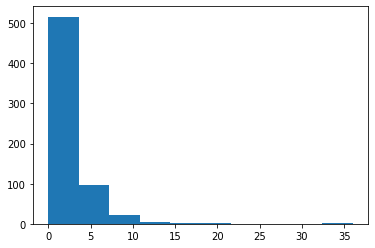

In [191]:
######################################
#                 13                 #
######################################

## Make histograms of the three metrics we looked at earlier for both
## students who passed the subway project and students who didn't. You
## might also want to make histograms of any other metrics you examined.

%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(passing_by_lessons.values())


(array([317.,  17.,   6.,   4.,   1.,   1.,   0.,   1.,   0.,   1.]),
 array([ 0. ,  2.7,  5.4,  8.1, 10.8, 13.5, 16.2, 18.9, 21.6, 24.3, 27. ]),
 <BarContainer object of 10 artists>)

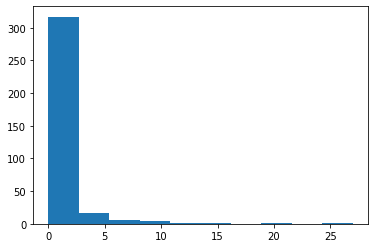

In [197]:
plt.hist(non_passing_by_lesson.values())

(array([370., 155.,  83.,  19.,  10.,   4.,   2.,   3.,   0.,   1.]),
 array([   0.        ,  356.47332645,  712.9466529 , 1069.41997935,
        1425.8933058 , 1782.36663225, 2138.8399587 , 2495.31328515,
        2851.7866116 , 3208.25993805, 3564.7332645 ]),
 <BarContainer object of 10 artists>)

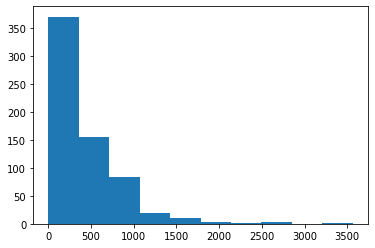

In [199]:
plt.hist(passing_by_minutes.values())


(array([272.,  34.,  17.,   9.,   6.,   2.,   1.,   5.,   0.,   2.]),
 array([   0.        ,  176.85227493,  353.70454987,  530.5568248 ,
         707.40909973,  884.26137467, 1061.1136496 , 1237.96592453,
        1414.81819947, 1591.6704744 , 1768.52274933]),
 <BarContainer object of 10 artists>)

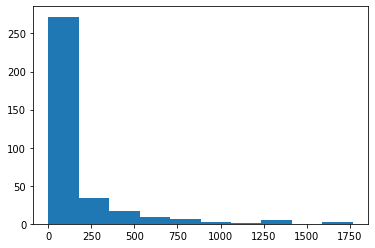

In [204]:
plt.hist(non_passing_by_minutes.values())


(array([87., 82., 79.,  0., 91., 77.,  0., 85., 78., 68.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

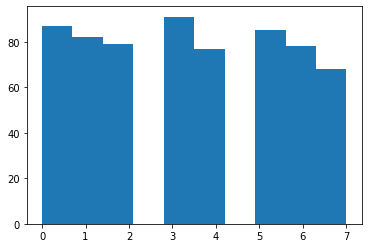

In [206]:
plt.hist(passing_by_visit.values())


(array([97., 90., 56.,  0., 41., 15.,  0., 24., 17.,  8.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

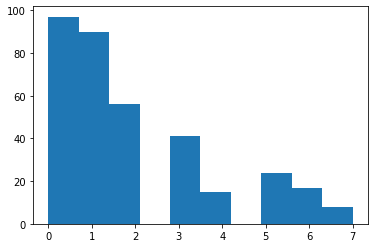

In [207]:
plt.hist(non_passing_by_visit.values())

## Improving Plots and Sharing Findings

Text(0, 0.5, 'Number of visits')

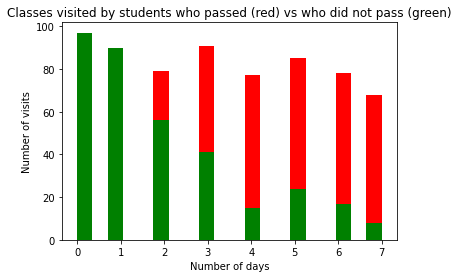

In [223]:
######################################
#                 14                 #
######################################

## Make a more polished version of at least one of your visualizations
## from earlier. Try importing the seaborn library to make the visualization
## look better, adding axis labels and a title, and changing one or more
## arguments to the hist() function.

plt.title('Classes visited by students who passed (red) vs who did not pass (green)')
BINS = 20

plt.hist(passing_by_visit.values(), bins=BINS, color='red')
plt.hist(non_passing_by_visit.values(), bins=BINS, color='green')
plt.xlabel('Number of days')
plt.ylabel('Number of visits )